## Import Dependencies

In [ ]:
from preprocess_container.data_utils import *
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from typing import Optional, List
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


## Load Data and Preprocess

In [ ]:
TRIMS = ["down", "up", "rnti_count", "rb_down", "rb_up"]
TIME_FEATURES = ["min_of_day", "day_of_week", "day_of_year"]
TIME_FEATURES = [f"{feature}_sin" for feature in TIME_FEATURES] + [f"{feature}_cos" for feature in TIME_FEATURES]

df = read_data(r"./dataset/full_dataset.csv", "PobleSec")
df = handle_nans(df)
df = df[TRIMS] # reduce feature set for testing
# df, scaler = scale_data(df)
df = time_to_feature(df)

df_eval = read_data(r"./dataset/PobleSec_test.csv")
df_eval = handle_nans(df_eval)
df_eval = df_eval[TRIMS]
# df_eval, _ = scale_data(df_eval, scale=scaler)
df_eval = time_to_feature(df_eval)


<class 'pandas.core.frame.DataFrame'>
                            down          up  rnti_count   rb_down     rb_up
time                                                                        
2018-02-05 23:40:00  109934672.0   1166592.0      6490.0  0.019056  0.000374
2018-02-05 23:42:00  243427312.0  26819240.0      7517.0  0.068725  0.018590
2018-02-05 23:44:00  490090984.0  63040432.0      7264.0  0.183461  0.047671
2018-02-05 23:46:00  949030475.0  87122240.0      7865.0  0.384327  0.057338
{'down': {Timestamp('2018-02-05 23:40:00'): 109934672.0, Timestamp('2018-02-05 23:42:00'): 243427312.0, Timestamp('2018-02-05 23:44:00'): 490090984.0, Timestamp('2018-02-05 23:46:00'): 949030475.0}, 'up': {Timestamp('2018-02-05 23:40:00'): 1166592.0, Timestamp('2018-02-05 23:42:00'): 26819240.0, Timestamp('2018-02-05 23:44:00'): 63040432.0, Timestamp('2018-02-05 23:46:00'): 87122240.0}, 'rnti_count': {Timestamp('2018-02-05 23:40:00'): 6490.0, Timestamp('2018-02-05 23:42:00'): 7517.0, Timestamp('

## Define Model

In [29]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, n_exo_features: int, hidden_size: int, output_size: int, num_layers: int=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.n_endo_features = input_size - n_exo_features
        self.n_exo_features = n_exo_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.n_features, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * self.n_endo_features)
    
    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, sequence_length, input_size).
        
        Returns:
            torch.Tensor: The output tensor from the model.
        """
        # --- Initialize Hidden and Cell States ---
        # The LSTM needs initial hidden and cell states. If not provided, they default to zeros.
        # The shape is (num_layers, batch_size, hidden_size).
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # --- LSTM Forward Pass ---
        # The LSTM returns the output of the entire sequence and the final hidden and cell states.
        # out shape: (batch_size, sequence_length, hidden_size)
        # hn shape: (num_layers, batch_size, hidden_size)
        # cn shape: (num_layers, batch_size, hidden_size)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # --- Fully-Connected Layer ---
        # We are interested in the output of the last time step for many sequence tasks
        # (e.g., classification, next value prediction).
        # out[:, -1, :] selects the output of the last element in the sequence for each batch.
        # Shape of out[:, -1, :]: (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        
        # Reshape the output to be (batch_size, output_seq_len, output_features)
        # This matches the shape of our target tensor.
        out = out.view(x.size(0), self.output_size, self.n_endo_features)
        
        return out

In [30]:
class GRU(nn.Module):
    def __init__(self, input_size: int, n_exo_features: int, hidden_size: int, output_size: int, num_layers: int=1):
        """
        Initializes the GRUModel.

        Args:
            input_size (int): The number of expected features in the input `x`.
            hidden_size (int): The number of features in the hidden state `h`.
            num_layers (int): Number of recurrent layers.
            output_size (int): The number of features in the output layer.
        """
        super(GRU, self).__init__() # Call the constructor of the parent class (nn.Module)
        self.input_size = input_size
        self.n_endo_features = input_size - n_exo_features
        self.n_exo_features = n_exo_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Define the GRU layer
        # batch_first=True means the input and output tensors are provided as (batch, seq, feature)
        # instead of (seq, batch, feature). This is generally more intuitive.
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # Define the fully connected layer that maps the hidden state to the desired output size
        self.fc = nn.Linear(hidden_size, output_size * self.n_endo_features)

    def forward(self, x):
        """
        Defines the forward pass of the GRU model.

        Args:
            x (torch.Tensor): The input tensor. Expected shape: (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: The output tensor. Expected shape: (batch_size, output_size).
        """
        # Initialize the hidden state with zeros
        # The hidden state has shape (num_layers * num_directions, batch_size, hidden_size).
        # For a simple GRU, num_directions is 1.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass the input through the GRU layer
        # output: tensor containing the output features (h_t) from the last layer of the GRU,
        #         for each t. Shape: (batch_size, sequence_length, hidden_size)
        # hn: tensor containing the hidden state for the last timestep of each layer.
        #     Shape: (num_layers * num_directions, batch_size, hidden_size)
        output, hn = self.gru(x, h0)

        # We are interested in the output from the last timestep of the last layer.
        # Since batch_first=True, output[:, -1, :] gives the output of the last timestep
        # for all sequences in the batch.
        # Then, pass this through the fully connected layer.
        out = self.fc(output[:, -1, :])

        out = out.view(x.size(0), self.output_size, self.n_endo_features)

        return out

In [31]:
class PositionalEncoding(nn.Module):
    """
    Standard positional encoding for adding positional information to the input embeddings.
    Required because Transformers are permutation-invariant without it.
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Add batch dimension: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, d_model).
        """
        # Add positional encoding to the input.
        # Ensure sequence_length of x does not exceed max_len
        x = x + self.pe[:, :x.size(1)] # type: ignore
        return x

class TETS(nn.Module):
    def __init__(self, input_size: int, output_size: int, n_exo_features: int, d_model: int = 128, nhead: int = 8, 
                 num_encoder_layers: int = 3, dim_feedforward: int = 512, dropout: float = 0.1):
        """
        Initializes the Transformer Encoder model for time series.

        Args:
            input_size (int): The number of features in each time step of the input.
            output_size (int): The length of the output sequence to be predicted.
            n_exo_features (int): The number of exogenous features.
            d_model (int): The dimension of the embeddings (and attention).
            nhead (int): The number of attention heads.
            num_encoder_layers (int): The number of stacked encoder layers.
            dim_feedforward (int): The dimension of the feedforward network model.
            dropout (float): The dropout value.
        """
        super(TETS, self).__init__()
        self.output_size = output_size
        self.n_endo_features = input_size - n_exo_features
        self.d_model = d_model

        # Linear layer to project input features to d_model dimension
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional Encoding to inject information about the position of each element in the sequence
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Final fully connected layer to map the Transformer's output to the desired prediction
        # We take the output of the last token (time step) from the Transformer.
        self.fc = nn.Linear(d_model, output_size * self.n_endo_features)

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the Transformer Encoder model.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: The output tensor from the model.
        """
        # Project input features to d_model dimension
        # Shape: (batch_size, sequence_length, d_model)
        x = self.input_projection(x)

        # Add positional encoding
        x = self.positional_encoding(x)

        # Pass through Transformer Encoder
        # Shape: (batch_size, sequence_length, d_model)
        transformer_output = self.transformer_encoder(x)

        # For time series forecasting, we often take the output of the last sequence element
        # as the representation from which to make the prediction.
        # Shape: (batch_size, d_model)
        last_time_step_output = transformer_output[:, -1, :]

        # Pass through the final fully connected layer
        # Shape: (batch_size, output_size * n_endo_features)
        out = self.fc(last_time_step_output)

        # Reshape the output to be (batch_size, output_size, n_endo_features)
        out = out.view(x.size(0), self.output_size, self.n_endo_features)

        return out

In [32]:
class Chomp1d(nn.Module):
    """
    To remove the padding introduced by causal convolution (padding applied only on the left).
    """
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    """
    A block in the Temporal Convolutional Network.
    Consists of two dilated causal convolutional layers, followed by
    weight normalization, ReLU, and dropout. Includes a residual connection.
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding) # Removes the padding
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        # Residual connection: if input and output feature dimensions differ, apply a 1x1 convolution
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        # Apply residual connection
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size: int, output_size: int, n_exo_features: int, 
                 num_channels: list, kernel_size: int = 2, dropout: float = 0.2):
        """
        Initializes the Temporal Convolutional Network model.

        Args:
            input_size (int): The number of features in each time step of the input.
            output_size (int): The length of the output sequence to be predicted.
            n_endo_features (int): The number of endogenous features to predict.
            num_channels (list): A list defining the number of output channels for each TemporalBlock.
            kernel_size (int): The size of the convolutional kernel for each block.
            dropout (float): The dropout value.
        """
        super(TCN, self).__init__()
        self.output_size = output_size
        self.n_endo_features = input_size - n_exo_features
        
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i # Exponentially increasing dilation
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            # Padding to ensure the output sequence length remains the same after causal convolution
            # padding = (kernel_size - 1) * dilation_size
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.tcn_layers = nn.Sequential(*layers)

        # Final fully connected layer to map the TCN's output to the desired prediction
        # We take the output of the last time step from the TCN.
        self.fc = nn.Linear(num_channels[-1], output_size * self.n_endo_features)

    def forward(self, x: torch.Tensor):
        """
        Defines the forward pass of the TCN model.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: The output tensor from the model.
        """
        # TCN expects input of shape (batch_size, features, sequence_length)
        # Our input is (batch_size, sequence_length, input_size), so we need to permute.
        x = x.permute(0, 2, 1) # Now x is (batch_size, input_size, sequence_length)

        # Pass through TCN layers
        # Shape: (batch_size, num_channels[-1], sequence_length)
        tcn_out = self.tcn_layers(x)

        # For time series forecasting, we typically take the output of the last time step
        # (which corresponds to the latest available information).
        # Shape: (batch_size, num_channels[-1])
        last_time_step_output = tcn_out[:, :, -1]

        # Pass through the final fully connected layer
        # Shape: (batch_size, output_size * n_endo_features)
        out = self.fc(last_time_step_output)

        # Reshape the output to be (batch_size, output_size, n_endo_features)
        out = out.view(x.size(0), self.output_size, self.n_endo_features)

        return out

## Convert from Dataframe to Numpy array input sequences

In [33]:
def window_data(df: pd.DataFrame, exo_features: Optional[List[str]] = None, input_len: int = 10, output_len: int = 1) -> tuple:
    """
    Splits the DataFrame into input features and target variables.
    """
    n_rows = df.shape[0]

    if exo_features is not None:
        x_df = df.copy()
        y_df = df.drop(columns=exo_features)
    else:
        x_df = df.copy()
        y_df = df
    
    x = np.zeros((n_rows, input_len, x_df.shape[1]), dtype=np.float32)
    y = np.zeros((n_rows, output_len, y_df.shape[1]), dtype=np.float32)

    for row in range(n_rows - input_len - output_len + 1):
        x[row, :input_len, :] = x_df.iloc[row:row+input_len, :].values
        y[row, :output_len, :] = y_df.iloc[row:row+output_len, :].values
    
    return x, y

X, y = window_data(df, TIME_FEATURES)
print(f"Shape of df: {df.shape}")
print(f"Shape of X (input sequences): {X.shape}")
print(f"Shape of y (output sequences): {y.shape}")

Shape of df: (15927, 11)
Shape of X (input sequences): (15927, 10, 11)
Shape of y (output sequences): (15927, 1, 5)


## Data Split

In [34]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Convert Numpy arrays to Torch tensors and then to data loaders

In [35]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train Tensor Shape: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, {y_test_tensor.shape}")

Train Tensor Shape: torch.Size([12741, 10, 11]), torch.Size([12741, 1, 5])
Test Tensor Shape: torch.Size([3186, 10, 11]), torch.Size([3186, 1, 5])


## Instantiate and train the model

In [36]:
# Hyperparameters
N_FEATURES = df.shape[1]
N_ENDO_FEATURES = df.shape[1] - len(TIME_FEATURES)  # Number of features in the input data
N_EXO_FEATURES = len(TIME_FEATURES)  # Number of exogenous features
OUTPUT_SEQ_LEN = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 3
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

NUM_HEADS = 8
FEEDFORWARD_DIM = 512

DROPOUT = 0.1

LAYER_ARCHITECTURE = [32, 64, 128, 256]
KERNEL_SIZE = 2


MODEL_TYPE = "TETS"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if MODEL_TYPE=="LSTM":
    model = LSTM(
        input_size=N_FEATURES, 
        n_exo_features=N_EXO_FEATURES, 
        hidden_size=HIDDEN_SIZE, 
        output_size=OUTPUT_SEQ_LEN,
        num_layers=NUM_LAYERS
    ).to(device)
elif MODEL_TYPE=="GRU":
    model = GRU(
        input_size=N_FEATURES, 
        n_exo_features=N_EXO_FEATURES, 
        hidden_size=HIDDEN_SIZE, 
        output_size=OUTPUT_SEQ_LEN,
        num_layers=NUM_LAYERS
    ).to(device)
elif MODEL_TYPE=="TETS":
    model = TETS(
        input_size=N_FEATURES,
        output_size=OUTPUT_SEQ_LEN,
        n_exo_features=N_EXO_FEATURES,
        d_model=HIDDEN_SIZE,
        nhead=NUM_HEADS,
        num_encoder_layers=NUM_LAYERS,
        dim_feedforward=FEEDFORWARD_DIM,
        dropout=DROPOUT
    ).to(device)
elif MODEL_TYPE=="TCN":
    model = TCN(
        input_size=N_FEATURES,
        output_size=OUTPUT_SEQ_LEN,
        n_exo_features=N_EXO_FEATURES,
        num_channels=LAYER_ARCHITECTURE,
        kernel_size=KERNEL_SIZE,
        dropout=DROPOUT
    )


criterion = nn.MSELoss()  # Mean Squared Error is a good choice for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device: cpu


## Training Loop

In [37]:
loss_history = []
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.6f}")

Epoch [1/50], Loss: 0.207041
Epoch [2/50], Loss: 0.098866
Epoch [3/50], Loss: 0.069153
Epoch [4/50], Loss: 0.102352
Epoch [5/50], Loss: 0.059277
Epoch [6/50], Loss: 0.042305
Epoch [7/50], Loss: 0.101196
Epoch [8/50], Loss: 0.053548
Epoch [9/50], Loss: 0.098678
Epoch [10/50], Loss: 0.033162
Epoch [11/50], Loss: 0.021807
Epoch [12/50], Loss: 0.040070
Epoch [13/50], Loss: 0.028343
Epoch [14/50], Loss: 0.052599
Epoch [15/50], Loss: 0.039797
Epoch [16/50], Loss: 0.023414
Epoch [17/50], Loss: 0.027322
Epoch [18/50], Loss: 0.016398
Epoch [19/50], Loss: 0.028142
Epoch [20/50], Loss: 0.019485
Epoch [21/50], Loss: 0.045924
Epoch [22/50], Loss: 0.051538
Epoch [23/50], Loss: 0.048250
Epoch [24/50], Loss: 0.028635
Epoch [25/50], Loss: 0.051300
Epoch [26/50], Loss: 0.034261
Epoch [27/50], Loss: 0.031217
Epoch [28/50], Loss: 0.024999
Epoch [29/50], Loss: 0.017065
Epoch [30/50], Loss: 0.023207
Epoch [31/50], Loss: 0.030828
Epoch [32/50], Loss: 0.025184
Epoch [33/50], Loss: 0.064501
Epoch [34/50], Loss

## Plot Training Loss

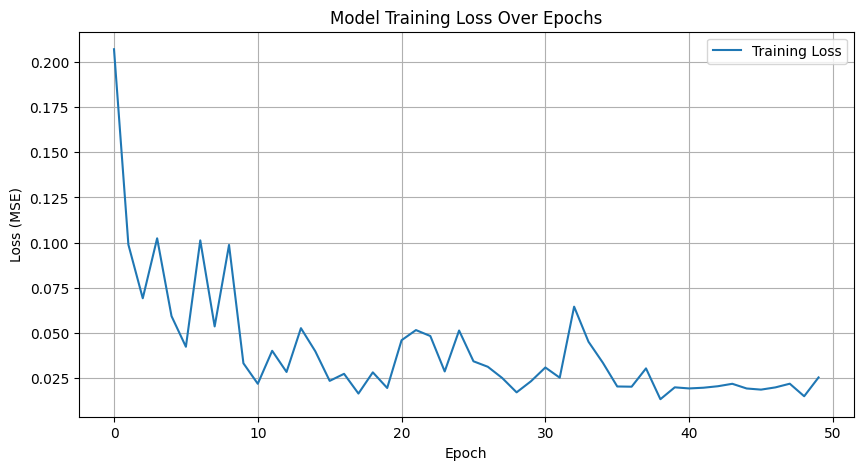

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Prepare Evaluation Data

In [39]:
X_eval, y_eval = window_data(df_eval, TIME_FEATURES)
X_eval_tensor = torch.from_numpy(X_eval).float()
y_eval_tensor = torch.from_numpy(y_eval).float()
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

## Infer via Recursive Forecast

In [40]:
model.eval()
SAMPLE_IDX = 0
INFERENCE_LENGTH = 720


# Determine the sampling frequency from the data
freq = check_uniform(df_eval)

# How much real data is available for the forecast window
remaining_real_data = X_eval.shape[0] - SAMPLE_IDX
available_future_steps = min(remaining_real_data, INFERENCE_LENGTH)
num_extension_steps = INFERENCE_LENGTH - available_future_steps

df_predictions = pd.DataFrame(
    index=pd.date_range(
        start=df_eval.index[SAMPLE_IDX],
        periods=INFERENCE_LENGTH,
        freq=freq
    ),
    columns=df_eval.columns
)

FEATURES = df_eval.columns.difference(TIME_FEATURES, sort=False).tolist()

df_predictions = time_to_feature(df_predictions)

current_sequence = X_eval_tensor[SAMPLE_IDX].unsqueeze(0).to(device)

with torch.no_grad():
    step = 0
    while step < INFERENCE_LENGTH:
        multi_step_pred = model(current_sequence)   # Shape: (1, OUTPUT_SEQ_LEN, num_features)
        remaining_steps = INFERENCE_LENGTH - step   # Decide how many of the predicted steps to use in this loop
        steps_to_use = min(OUTPUT_SEQ_LEN, remaining_steps)

        for i in range(steps_to_use):
            absolute_step = step + i
            next_step = absolute_step + 1
            if absolute_step >= INFERENCE_LENGTH:
                break

            # Get prediction and store it
            current_pred = multi_step_pred[:, i, :].cpu().numpy().flatten()
            df_predictions.loc[df_predictions.index[absolute_step], FEATURES] = current_pred

            # Update sequence
            if next_step <= available_future_steps:
                current_sequence = X_eval_tensor[SAMPLE_IDX + next_step].unsqueeze(0).to(device)
            else:
                extension_idx = next_step - available_future_steps
                print("CALLED EXTENSION MODE")

                if extension_idx < df_predictions.shape[0]:
                    # Extract future exogenous data from df_extension
                    extension_row = df_predictions.iloc[[extension_idx]][TIME_FEATURES]
                    numpy_extension, _ = window_data(
                        extension_row,
                        TIME_FEATURES,
                        input_len=1, output_len=1
                    )
                    exog_tensor = torch.from_numpy(numpy_extension).float()
                    pred_tensor = torch.tensor(current_pred).view(1, 1, -1)
                    print(f"Current Sequence shape: {current_sequence.shape}")
                    print(f"Prediction Tensor shape: {pred_tensor.shape}")
                    print(f"Exogenous Tensor shape: {exog_tensor.shape}")

                    current_pred = torch.cat((pred_tensor, exog_tensor), dim=-1)
                    current_sequence = torch.cat((current_sequence[:, 1:, :], current_pred), dim=1)
                else:
                    print(f"[Warning] df_extension exhausted at index {extension_idx}")
                    break

        step += steps_to_use


df_predictions = df_predictions.drop(columns=TIME_FEATURES)
df_ml = pd.DataFrame(
    scaler.inverse_transform(df_predictions),
    index=df_predictions.index,
    columns=df_predictions.columns
)

print(f"Inference completed:")
print(f"- Used actual future values for first {min(available_future_steps, INFERENCE_LENGTH)} steps")
if INFERENCE_LENGTH > available_future_steps:
    print(f"- Switched to recursive mode after step {available_future_steps}")
print(f"- Model predicts {OUTPUT_SEQ_LEN} step(s) at a time")
print(f"- Total predictions generated: {df.shape[0]}")

# Get the corresponding actual future values from the test set for comparison
# Make sure we only get as many actual values as we have predictions
actual_length = min(len(y_eval) - SAMPLE_IDX, df.shape[0])
actual_values_scaled = y_eval[SAMPLE_IDX : SAMPLE_IDX + actual_length]

# Reshape the actual values to match prediction format
actual_values_scaled = actual_values_scaled.reshape(-1, N_ENDO_FEATURES)

# Unscale the actual values to their original representation
actual_values_unscaled = scaler.inverse_transform(actual_values_scaled)

Inference completed:
- Used actual future values for first 720 steps
- Model predicts 1 step(s) at a time
- Total predictions generated: 15927


## Visualize the Inference

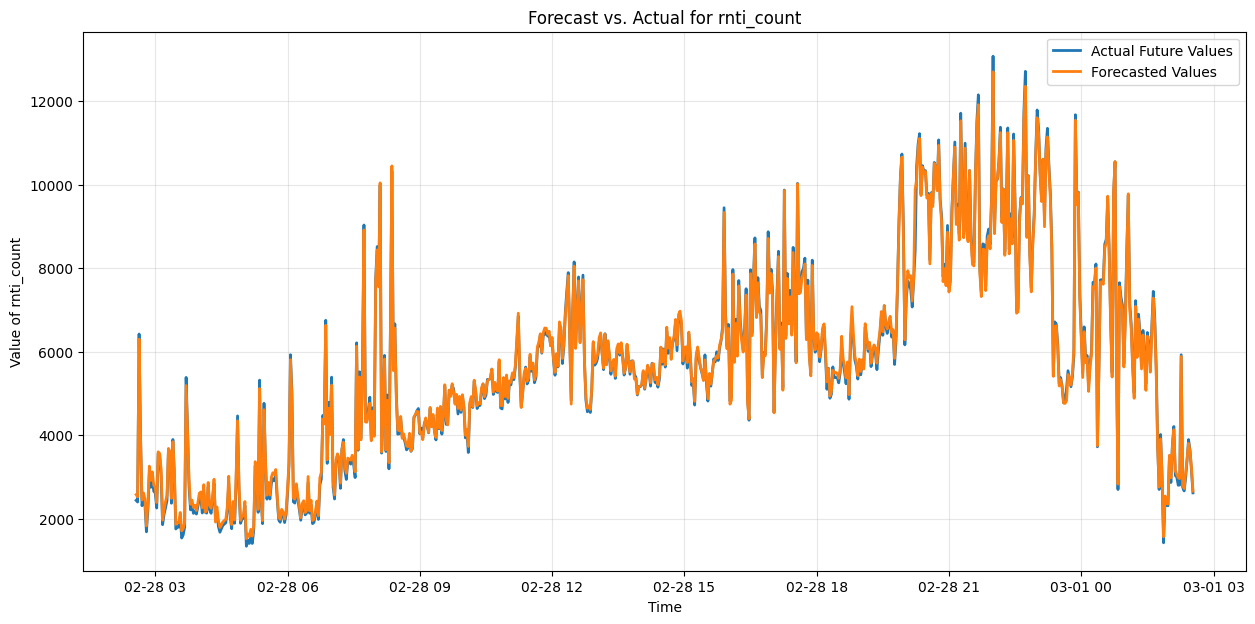

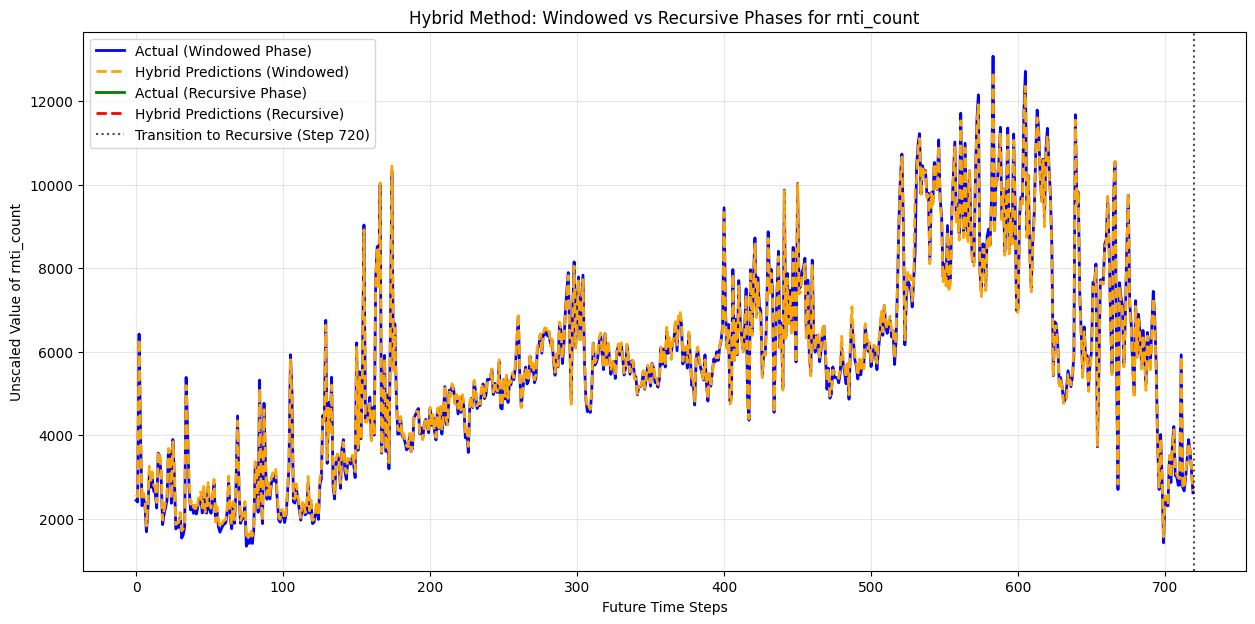

In [41]:
plt.figure(figsize=(15, 7))

# Select which feature to plot (0 for first feature, etc.)
feature_to_plot = 2
column_name = df_ml.columns[feature_to_plot]
feature_name = f"{column_name}"  # Use actual column name

# x_axis should match df_ml's index (already aligned with prediction timestamps)
x_axis = df_ml.index

# Plot the unscaled data for a meaningful comparison
plt.plot(x_axis, actual_values_unscaled[:INFERENCE_LENGTH, feature_to_plot], '-', label='Actual Future Values', linewidth=2)
plt.plot(x_axis, df_ml[column_name], '-', label='Forecasted Values', linewidth=2)

plt.title(f'Forecast vs. Actual for {feature_name}')
plt.xlabel('Time')
plt.ylabel(f'Value of {feature_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# --- Additional Analysis: Show where method switched from windowed to recursive ---
if len(actual_values_unscaled) > available_future_steps:
    plt.figure(figsize=(15, 7))

    # Plot windowed phase
    windowed_x = np.arange(available_future_steps)
    plt.plot(windowed_x, actual_values_unscaled[:available_future_steps, feature_to_plot], 
             '-', label='Actual (Windowed Phase)', linewidth=2, color='blue')
    plt.plot(windowed_x, df_ml.iloc[:available_future_steps, feature_to_plot], 
             '--', label='Hybrid Predictions (Windowed)', linewidth=2, color='orange')

    # Plot recursive phase
    recursive_x = np.arange(available_future_steps, INFERENCE_LENGTH)
    plt.plot(recursive_x, actual_values_unscaled[available_future_steps:INFERENCE_LENGTH, feature_to_plot], 
             '-', label='Actual (Recursive Phase)', linewidth=2, color='green')
    plt.plot(recursive_x, df_ml.iloc[available_future_steps:INFERENCE_LENGTH, feature_to_plot], 
             '--', label='Hybrid Predictions (Recursive)', linewidth=2, color='red')

    # Add vertical line to show transition
    plt.axvline(x=available_future_steps, color='black', linestyle=':', alpha=0.7, 
                label=f'Transition to Recursive (Step {available_future_steps})')

    plt.title(f'Hybrid Method: Windowed vs Recursive Phases for {feature_name}')
    plt.xlabel('Future Time Steps')
    plt.ylabel(f'Unscaled Value of {feature_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



## Optional NonML Methods

In [91]:
from pandas.tseries.frequencies import to_offset

timedelta = check_uniform(df)
freq_str = to_offset(timedelta).freqstr # type: ignore

print(freq_str)

2min


In [98]:
from statsforecast import StatsForecast
from statsforecast.models import (                                                                                              # type: ignore
    AutoARIMA, # AutoRegressive Integrated Moving Average
    AutoETS, # Exponential Smoothing
    AutoTheta,
    AutoMFLES,
    AutoTBATS # Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend components, Seasonal components
)

n = 2
FREQ=f"{n}min"
SL = int(24*60 / n)
print(SL)

# 8min | 3983 | 52:47
# 10min | 3186 |
# 20min | 1593 | 


df_sf = df.copy().resample(FREQ).mean()
print(df_sf.shape)
df_sf["unique_id"] = "1"  # Statsforecast requires a unique_id for each time series
df_sf.index.rename("ds", inplace=True)
df_sf = df_sf.reset_index()
df_sf.rename(columns={"down": "y"}, inplace=True)
df_sf = df_sf[["unique_id", "ds", "y"] + TIME_FEATURES]

df_true = df_eval.copy().resample(FREQ).mean()
print(df_true.shape)
df_true["unique_id"] = "1"
df_true.index.rename("ds", inplace=True)
df_true = df_true.reset_index()
X_df = df_true.drop(columns=TRIMS)


# AutoARIMA(season_length=SL)
# AutoETS(season_length=SL, model="ZNZ")
# AutoTheta(season_length=SL)
# AutoMFLES(season_length=[SL, SL*7], test_size=15)
# AutoTBATS(season_length=[SL, SL*7])

sf = StatsForecast(
    models=[AutoMFLES(season_length=SL, test_size=1)],
    freq=FREQ,
    n_jobs=-1,

)

sf.fit(df_sf)

720
(15927, 11)
(3982, 11)


StatsForecast(models=[AutoMFLES])

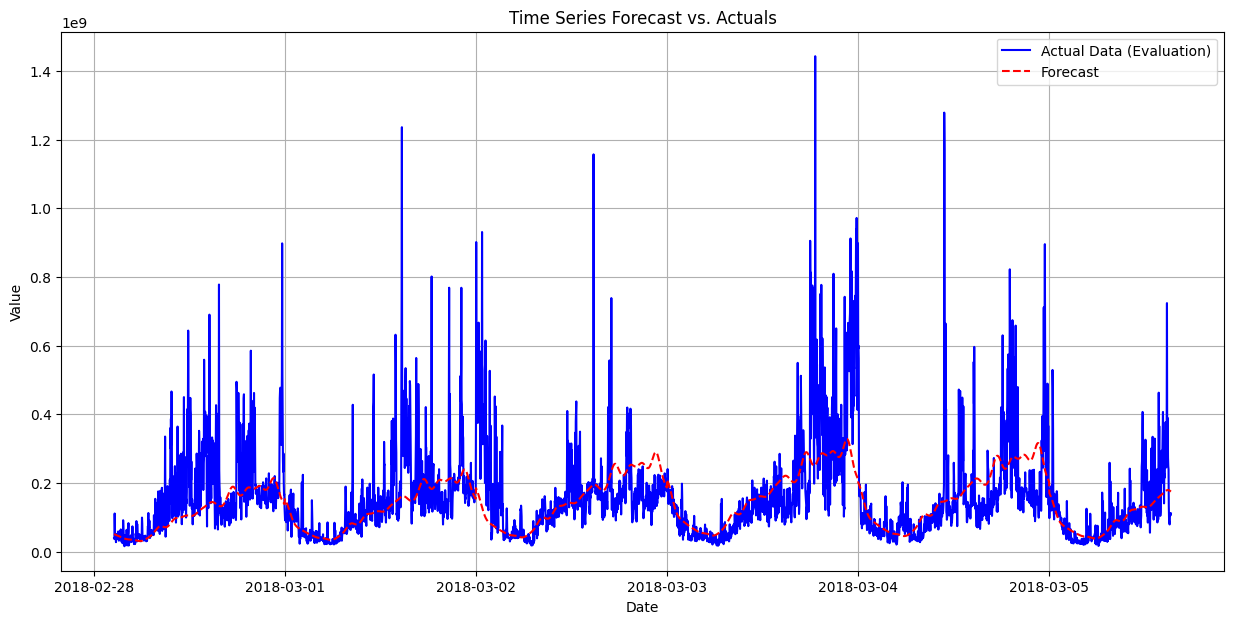

In [99]:

forecast_df = sf.predict(h=df_true.shape[0], X_df=X_df)

plt.figure(figsize=(15, 7))

# Plot the actual evaluation data
plt.plot(df_true['ds'], df_true['down'], label='Actual Data (Evaluation)', color='blue')

# Plot the forecast predictions
plt.plot(forecast_df['ds'], forecast_df['AutoMFLES'], label='Forecast', color='red', linestyle='--')

# Add labels and title
plt.title('Time Series Forecast vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Prophet

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
import plotly.graph_objects as go
import itertools

df_prophet = pd.DataFrame({"ds": df.index, "y": df[column_name]})
td = df_prophet['ds'].max() - df_prophet['ds'].min()
print(td)
data_len = td.total_seconds() / pd.Timedelta(days=1).total_seconds()


[[1, 2, 3, 4, 5, 6]]


### Prophet Parameter Grid Search

In [18]:
param_grid = {
    "changepoint_prior_scale": [0.1],
    "seasonality_prior_scale": [10],
    "seasonality_mode": ['additive', 'multiplicative'],
    "fourier_order": [20],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
results = []  # store results

for params in all_params:
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        seasonality_mode=params["seasonality_mode"],
        changepoint_prior_scale=params["changepoint_prior_scale"], # Sensitivity to changes in trend
        seasonality_prior_scale=params["seasonality_prior_scale"] # Strength of the seasonality component
    )
    m.add_seasonality(
        name='daily',
        period=1,
        fourier_order=params["fourier_order"]
    )
    m.add_seasonality(
        name='hourly', 
        period=1/24, 
        fourier_order=10
    )

    try:
        m.fit(df_prophet)

        df_cv = cross_validation(
            m, 
            initial=f"{round(0.6*data_len)} days", 
            period=f"{round(0.15*data_len)} days", 
            horizon=f"{round(0.1*data_len)} days",
            parallel="processes"
        )

        df_p = performance_metrics(df_cv, rolling_window=1)

        result = {
            'params': params,
            'mape': df_p['mape'].values[0],
            'rmse': df_p['rmse'].values[0]
        }
        results.append(result)

    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        continue

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='rmse', ascending=True)
best_params = results_df.iloc[0]['params']
print(f"Best params: {best_params}")

13:34:00 - cmdstanpy - INFO - Chain [1] start processing
13:34:06 - cmdstanpy - INFO - Chain [1] done processing
13:34:20 - cmdstanpy - INFO - Chain [1] start processing
13:34:38 - cmdstanpy - INFO - Chain [1] done processing


Best params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'seasonality_mode': 'additive', 'fourier_order': 20}


### Plotting Best Model

In [19]:
m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        seasonality_mode=best_params["seasonality_mode"],
        changepoint_prior_scale=best_params["changepoint_prior_scale"], # Sensitivity to changes in trend
        seasonality_prior_scale=best_params["seasonality_prior_scale"] # Strength of the seasonality component
)
m.add_seasonality(
        name='daily',
        period=1,
        fourier_order=best_params["fourier_order"]
)
m.add_seasonality(
    name='hourly', 
    period=1/24, 
    fourier_order=10
)


m.fit(df_prophet)
future = m.make_future_dataframe(periods=0, freq=freq)
forecast = m.predict(future)
fig = plot_plotly(m, forecast)
fig.show()

13:35:19 - cmdstanpy - INFO - Chain [1] start processing
13:35:24 - cmdstanpy - INFO - Chain [1] done processing
